In [1]:
import os
import cv2 
from matplotlib import pyplot as plt
import numpy as np

In [31]:
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = cv2.DrawMatchesFlags_DEFAULT)

def extract_sift_features(img):
    sift = cv2.SIFT_create()
    kp, features = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), None)
    return kp, features

def match_sift_features(des1, des2):
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    return matches

def sift_match_images(img1, img2):
    kp1, des1 = extract_sift_features(img1)
    kp2, des2 = extract_sift_features(img2)
    matches = match_sift_features(des1, des2)
    return matches, kp1, kp2

def get_good_matches(matches):
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
    return sorted(good, key = lambda x: x[0].distance)

def draw_matches(matches, img1, img2, kp1, kp2):
    m_img = cv2.drawMatchesKnn(
    img1, kp1,
    img2, kp2,
    matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(m_img)
    plt.axis("off")
    return None

def stack_A(kp1, kp2):
    A_0 = np.zeros((1,9))
    x = kp1.pt[0]
    y = kp1.pt[1]
    x_dash = kp2.pt[0]
    y_dash = kp2.pt[1]
    A_0 = np.array([x*x_dash, x*y_dash, x, y*x_dash, y*y_dash, y, x_dash, y_dash, 1])
    return A_0

def estimate_F(kps1, kps2):
    A = np.zeros((8,9))
    for i in range(8):
        A[i] = stack_A(kps1[i], kps2[i])
    U, S, Vt = np.linalg.svd(A, full_matrices=True)
    F = Vt[-1].reshape(3,3)
    u, s, vt = np.linalg.svd(F, full_matrices=True)
    sd = np.diag(s)
    sd[2,2] = 0
    F = np.dot(u, np.dot(sd, vt))
    return F

def get_keypoints(matches, kp1, kp2):
    img1_kp_list = []
    img2_kp_list = []
    for i in matches:
        qidx = i[0].queryIdx
        tidx = i[0].trainIdx
        kp1_xy = kp1[qidx]
        kp2_xy = kp2[tidx]
        img1_kp_list.append(kp1_xy)
        img2_kp_list.append(kp2_xy)
    return img1_kp_list, img2_kp_list
    
def normalize_points(pts):
    pts = np.array(pts)
    
def RANSAC_F(good_matches, kp1, kp2, steps=10, eps=0.1):
    F = None
    inliers = None
    max_inliners = None
    return F, inliers, max_inliers

def estimate_E(k, F):
    E = np.dot(np.dot(k.T, F), k)
    U, S, Vt = np.linalg.svd(E)
    S = np.diag((1,1,0))
    E = np.dot(np.dot(U, S), Vt)
    return E

def get_camera_pose(E):
    W = np.array([0, -1, 0, 1, 0, 0, 0, 0, 1]).reshape(3,3)
    U, D, Vt = np.linalg.svd(E)
    c1 = (U[:, 2], np.dot(np.dot(U, W), Vt))
    c2 = (-U[:, 2], np.dot(np.dot(U, W), Vt))
    c3 = (U[:, 2], np.dot(np.dot(U, W.T), Vt))
    c4 = (-U[:, 2], np.dot(np.dot(U, W.T), Vt))
    if np.linalg.det(c1[1]) < 0: c1 *= -1.0
    if np.linalg.det(c2[1]) < 0: c2 *= -1.0
    if np.linalg.det(c3[1]) < 0: c3 *= -1.0
    if np.linalg.det(c4[1]) < 0: c4 *= -1.0
    return c1, c2, c3, c4

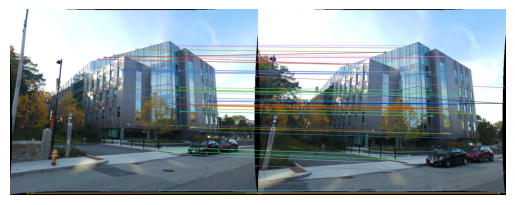

In [32]:
img = [cv2.cvtColor(cv2.imread(os.path.join(BASE_DIR, image_names[i])), cv2.COLOR_BGR2RGB) for i in range(5)] 
matches, kp1, kp2 = sift_match_images(img[0], img[1])
good_matches = get_good_matches(matches)[:50]
draw_matches(good_matches, img[0], img[1], kp1, kp2)
keypoints1, keypoints2 = get_keypoints(good_matches, kp1, kp2)
F = estimate_F(keypoints1[:8], keypoints2[:8])
E = estimate_E(K, F)
camera_pose = get_camera_pose(E)

In [36]:
pose = camera_pose[0]

In [48]:
P = np.dot(np.dot(K, pose[0]), np.hstack((np.identity(3), pose[1])))

In [49]:
camera_pose[0]

(array([0.00996582, 0.99794632, 0.06327586]),
 array([[-0.84942919,  0.07306344,  0.52262011],
        [ 0.36956968,  0.7893028 ,  0.49032575],
        [-0.37668062,  0.60964156, -0.69745887]]))